In [1]:
from accpy.math.specialfuns import squarespace
from accpy.jupyter.visual import autoscroll, plotstandard, figsave, rctablet, rcpof
from accpy.dataio.hdf5 import h5load, h5save
# from pyfftw import empty_aligned
# from pyfftw.pyfftw import FFTW
from ipywidgets import FloatSlider, widgets
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import axes3d, art3d
from jupyterthemes import jtplot
%matplotlib notebook
%matplotlib notebook
jtplot.style('monokai')
jtplot.style('monokai')
autoscroll(1000)

twopi = 2*pi
layout = {'width':'90%', 'height': '80px', 'border': 'solid'}
style = {'handle_color': 'red'}

# def getmyfft(turns, frev):
#     dQ = linspace(0, 1/2, int(turns/2))
#     fdn = concatenate((fd, -fd[::-1]))
#     a = empty_aligned(turns, dtype='complex128')
#     b = empty_aligned(turns, dtype='complex128')
#     myfft = FFTW(a, b, threads=2)
#     return dQ, fd, fdn, myfft

def initfigs(points, ms, bw, n=2, m=2, fs=[1920/120, 1080/120]):
    colors = cm.rainbow(linspace(0, 1, points))
    lines = []
    x = ['q', 't', 't', 'q']
    y = ['p', 'q', 'p', r'$E_{pot}$ & $E_{tot}$']
    fig1, axes = subplots(n, m, figsize=fs)
    axes  = [ax for subaxes in axes for ax in subaxes]
    for i, ax in enumerate(axes):
        ax.grid(True)
        ax.set_xlabel(x[i])
        ax.set_ylabel(y[i])
        lines.append([])
        for col in colors:
            lines[i].append(ax.plot([], [], '.', c=col, ms=ms)[0])
        if i in [1, 3]:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position('right')
    lines.append(axes[-1].plot([], [], '-', c=bw)[0])
    fig1.tight_layout(rect=[0, 0, 1, .9])
    fig2 = figure(figsize=fs)
    ax3D = fig2.add_subplot(111, projection='3d')
    fig2.tight_layout()
    return fig1, fig2, axes, lines, ax3D

def init(T, q0, p0, points, bw, ms=1, fs=[12, 10]):
    t = arange(0, T, dt)
    iterations = len(t)
    q, p, U = [empty([iterations, points]) for i in range(3)]
    q[0, :], p[0, :] = q0, p0
    fig1, fig2, axes, lines, ax3D =  initfigs(points, ms, bw, n=2, m=2, fs=fs)
    return fig1, fig2, axes, lines, ax3D, t, iterations, q, p, U

def lims(mplotlims):
        scale = 1.021
        offset = (mplotlims[1] - mplotlims[0])*scale
        return mplotlims[1] - offset, mplotlims[0] + offset

def run(Tkin, Upot, eom, axes, lines, ax3D, t, iterations, q, p, U, dt, bw):
    for it in range(1, iterations):
        q0, p0 = q[it-1, :], p[it-1, :]
        U[it-1, :] = Upot(q0) + Tkin(p0)
        q[it, :], p[it, :] = eom(q0, p0)
    q0, p0 = q[it, :], p[it, :]
    U[it, :] = Upot(q0) + Tkin(p0)
    for i, [line0, line1, line2, line3] in enumerate(zip(lines[0], lines[1], lines[2], lines[3])):
        qdat, pdat = q[:, i], p[:, i]
        line0.set_data(qdat, pdat)
        line1.set_data(t, qdat)
        line2.set_data(t, pdat)
        line3.set_data(qdat, U[:, i])
    qmin, qmax, pmin, pmax = np.nanmin(q), np.nanmax(q), np.nanmin(p), np.nanmax(p)
    qrange = linspace(qmin, qmax, iterations)
    lines[4].set_data(qrange, Upot(qrange))
    for ax in axes:
        ax.relim()
        ax.autoscale_view(True,True,True)
    res = int(2e2)
    qmesh, pmesh = meshgrid(linspace(qmin, qmax, res), linspace(pmin, pmax, res))
    Hmesh = Tkin(pmesh) + Upot(qmesh)
    ax3D.clear()
    surf = ax3D.plot_surface(qmesh, pmesh, Hmesh, rstride=8, cstride=8, alpha=0.3, cmap='hot')
    xlims, ylims, zlims = lims(ax3D.get_xlim()), lims(ax3D.get_ylim()), lims(ax3D.get_zlim())
    ax3D.contour(qmesh, pmesh, Hmesh, zdir='x', cmap=cm.coolwarm, offset=xlims[0])
    ax3D.contour(qmesh, pmesh, Hmesh, zdir='y', cmap=cm.coolwarm, offset=ylims[1])
    ax3D.contour(qmesh, pmesh, Hmesh, zdir='z', cmap=cm.coolwarm, offset=zlims[0])
    i = array([xlims[0], ylims[0], zlims[0]])
    f = array([xlims[0], ylims[0], zlims[1]])
    p = art3d.Poly3DCollection(array([[i, f]]))
    p.set_color(bw)
    ax3D.xaxis.pane.set_edgecolor(bw)
    ax3D.yaxis.pane.set_edgecolor(bw)
    ax3D.zaxis.pane.set_edgecolor(bw)
    ax3D.add_collection3d(p)
    ax3D.set_xlabel('q')
    ax3D.set_ylabel('p')
    ax3D.set_zlabel('E')
    ax3D.xaxis.pane.set_alpha(1)
    ax3D.yaxis.pane.set_alpha(1)
    ax3D.zaxis.pane.set_alpha(1)
    ax3D.xaxis.pane.fill = False
    ax3D.yaxis.pane.fill = False
    ax3D.zaxis.pane.fill = False
#     ax3D.xaxis.set_major_locator(MultipleLocator(5))
#     ax3D.yaxis.set_major_locator(MultipleLocator(30))
#     ax3D.zaxis.set_major_locator(MultipleLocator(1000))
    return

def rctablet():
    jtplot.style('monokai')
    fs = [2048/256, 1536/256]
    rcParams['savefig.format'] = 'png'
    rcParams['savefig.dpi'] = 256
    rcParams['savefig.facecolor'] = '#232323'
    rcParams['savefig.edgecolor'] = '#232323'
    rcParams['savefig.transparent'] = False
    rcParams['savefig.pad_inches'] = 0.0
    rcParams['nbagg.transparent'] = False
    return fs, 'w'

def rcprint():
    jtplot.style('grade3')
    fs = [2048/256, 1536/256]
    rcParams['savefig.format'] = 'png'
    rcParams['savefig.dpi'] = 256
    rcParams['savefig.transparent'] = False
    rcParams['savefig.pad_inches'] = 0.0
    rcParams['nbagg.transparent'] = False
    rcParams['legend.facecolor'] = 'inherit'
    return fs, 'k'

# fs, bw = rctablet()
# fs, bw = rcprint()
# numpy.seterr(all='raise')

/home/inp/virtualenv/py27env/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<IPython.core.display.Javascript object>

<H2>Harmonic Oscillator</H2>
<h3>\begin{align}
      H(q, p, t) &= \frac{p^2}{2m} + \frac{\omega^2}{2}q^2 \\
         \dot{q} &= +\frac{\partial H}{\partial p} = \frac{p}{m} \\
         \dot{p} &= -\frac{\partial H}{\partial q} = -\omega^2q \\
                 &\rightarrow m\ddot{q} + \omega^2q = 0
\end{align}</h3>

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description=u'f', layout=Layout(border=u'solid', height=u'80px', width=u'90%'), max=50.0, min=1.0, step=1.0, style=SliderStyle(handle_color='red')), Output()), _dom_classes=('widget-interact',))

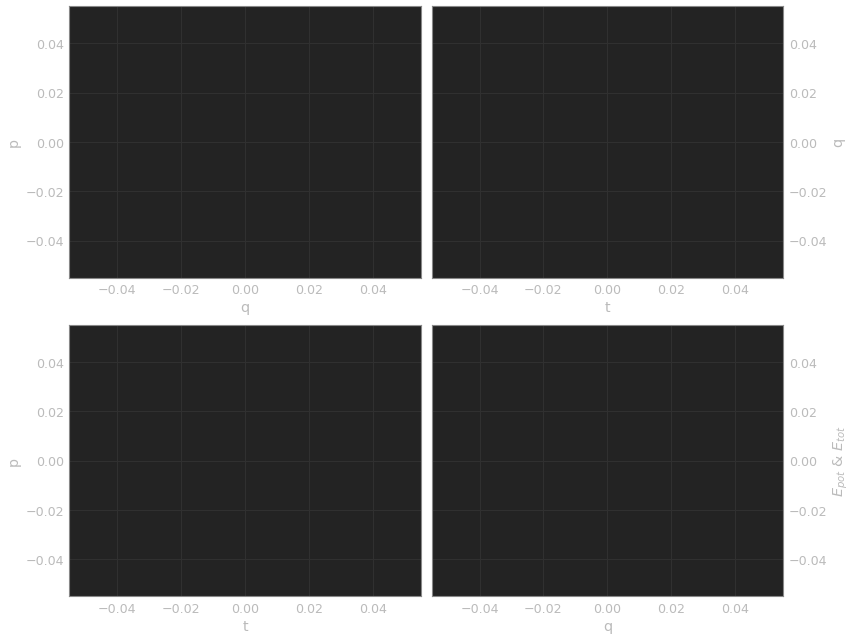

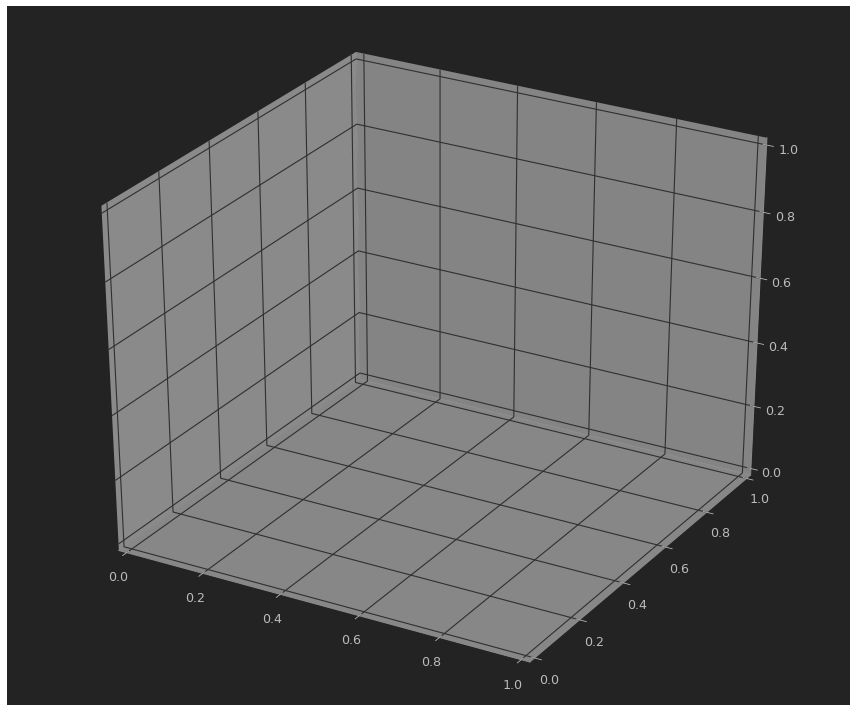

In [2]:
def Tkin(p, m):
    return p**2/2/m
    
def Upot(q, w):
    return w**2*q**2/2

def eom(q0, p0, dt, m, w):
#    #### SEMI IMPLICIT EULER (1st Order (O(dt)) simplectic)
#     dp = - w**2*q0*dt
#     p = p0 + dp
#     dq = p/m*dt
#     q = q0 + dq
    #### REVERSE SEMI IMPLICIT EULER (1st Order (O(dt)) simplectic)
    dq = p0/m*dt
    q = q0 + dq
    dp = - w**2*q*dt
    p = p0 + dp
    #### COMBINATION OF THE TWO GIVES THE LEAPFROG (2nd order, STÖRMER-VERLET = slightly different)
    return q, p

# calculation settings
points = int(21)
dt = 1e-3  # in s
T = 1      # in s  (iterations = T/dt)
q0 = linspace(.5, 10, points)
p0 = linspace(0, 0, points)

### INTERACTIVE
m = 1
fig1, fig2, axes, lines, ax3D, t, iterations, q, p, U = init(T, q0, p0, points, 'w')
slides = widgets.interactive(lambda f: run(lambda p: Tkin(p, m),
                                           lambda q: Upot(q, twopi*f),
                                           lambda q, p: eom(q, p, dt, m, twopi*f),
                                           axes, lines, ax3D, t, iterations, q, p, U, dt, 'w'),
                                           f=FloatSlider(min=1, max=50, step=1, continuous_update=False, layout=layout, style=style))
display(slides)

### PREDEFINED
# def makeplots(fs, bw, path):
#     fig1, fig2, axes, lines, ax3D, t, iterations, q, p, U = init(T, q0, p0, points, bw, fs=fs)
#     m, f =1, 1
#     run(lambda p: Tkin(p, m), lambda q: Upot(q, twopi*f), lambda q, p: eom(q, p, dt, m, twopi*f),
#         axes, lines, ax3D, t, iterations, q, p, U, dt, bw)
#     fig1.suptitle(r'1D Harmonic Oscillator $H(q, p, t) = \frac{p^2}{2m} + \frac{\omega^2}{2}q^2$')
#     fig1.savefig(path + '20171103_1DHO_dt1e-4')
#     fig2.savefig(path + '20171103_1DHO_dt1e-4_mplot3d')
#     return
# fs, bw = rctablet()
# path = '/home/inp/git/github/promotion/publications/diashow/plotstyle_monokai/'
# makeplots(fs, bw, path)

# fs, bw = rcprint()
# path = '/home/inp/git/github/promotion/publications/diashow/plotstyle_grade3/'
# makeplots(fs, bw, path)
# show()

<H2>Pendulum</H2>
<h3>\begin{align}
      H(q, p, t) &= \frac{p^2}{2mR^2} + mgR\left(1-\cos(q)\right)\\
         \dot{q} &= \frac{p}{mR^2} \\
         \dot{p} &= -mgR\sin(q) \\
                 &\rightarrow \ddot{q} + \frac{g}{R}\sin(q) = 0
\end{align}</h3>

<IPython.core.display.Javascript object>


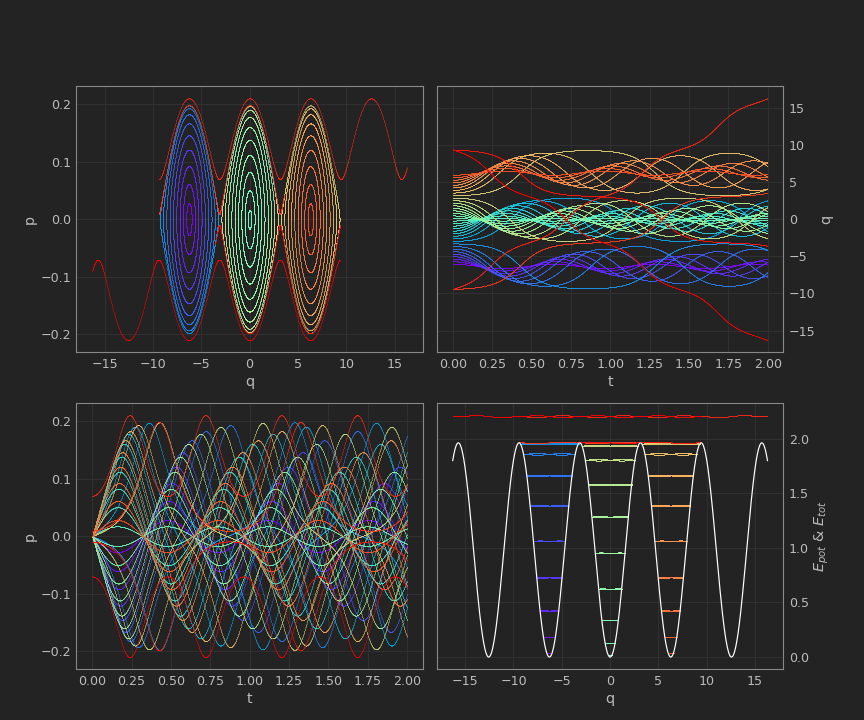

<IPython.core.display.Javascript object>


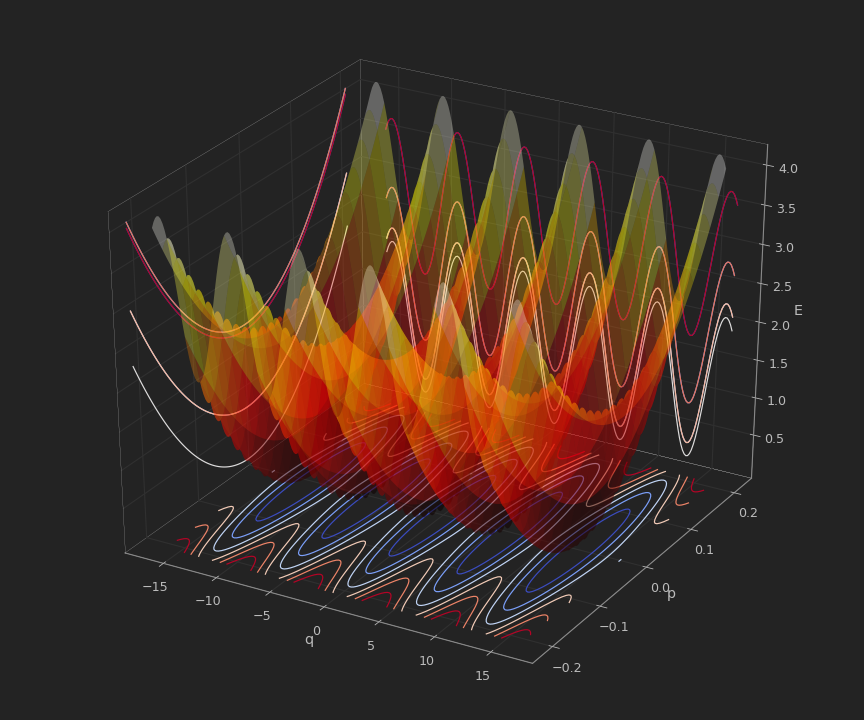

A Jupyter Widget

In [88]:
def Tkin(p, m, R):
    return p**2/2/m/R**2
    
def Upot(q, m, g, R):
    return m*g*R*(1-cos(q))

def eom(q0, p0, dt, m, g, R):
    dp = -m*g*R*sin(q0)*dt
    p = p0 + dp
    dq = p/(m*R**2)*dt
    q = q0 + dq
    return q, p

#### INTERACTIVE
points = int(40)
dt = 1e-3   # in s
T = 2      # in s  (iterations = T/dt)
g = 9.81
q0 = concatenate([linspace(-6, 6, points-4), array([-9.4, -9.4, 9.4, 9.4])])
p0 = concatenate([linspace(0, 0, points-4), array([9.5e-3, 7e-2, -9.5e-3, -7e-2])])
fig1, fig2, axes, lines, ax3D, t, iterations, q, p, U = init(T, q0, p0, points, 'w')
slides = widgets.interactive(lambda m, R: run(lambda p: Tkin(p, m, R),
                                              lambda q: Upot(q, m, g, R),
                                              lambda q, p: eom(q, p, dt, m, g, R),
                                              axes, lines, ax3D, t, iterations, q, p, U, dt, 'w'),
                                              m=FloatSlider(min=1, max=100, step=1, continuous_update=False, layout=layout, style=style),
                                              R=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False, layout=layout, style=style))
display(slides)

#### PREDEFINED
# points = int(40)
# dt = 1e-4   # in s
# T = 2      # in s  (iterations = T/dt)
# g = 9.81
# q0 = concatenate([linspace(-6, 6, points-4), array([-9.4, -9.4, 9.4, 9.4])])
# p0 = concatenate([linspace(0, 0, points-4), array([9.5e-3, 7e-2, -9.5e-3, -7e-2])])
# m, R = 1, 0.1

# def makeplots(fs, bw, path):
#     fig1, fig2, axes, lines, ax3D, t, iterations, q, p, U = init(T, q0, p0, points, bw, fs=fs)
#     m, f, a0, a1, a2, a3, a4 = 1, twopi*0.01, 0, 0, 0, 0, 1.3e3  # many fake FP
#     run(lambda p: Tkin(p, m, R),
#         lambda q: Upot(q, m, g, R),
#         lambda q, p: eom(q, p, dt, m, g, R),
#         axes, lines, ax3D, t, iterations, q, p, U, dt, bw)
#     fig1.suptitle(r'Pendulum $H(q, p, t) &= \frac{p^2}{2mR^2} + mgR\left(1-\cos(q)\right)$')
#     fig1.savefig(path + '20171108_Pendulum_dt1e-4')
#     fig2.savefig(path + '20171108_Pendulum_dt1e-4_mplot3d')
#     return

# fs, bw = rctablet()
# path = '/home/inp/git/github/promotion/publications/diashow/plotstyle_monokai/'
# makeplots(fs, bw, path)

# fs, bw = rcprint()
# path = '/home/inp/git/github/promotion/publications/diashow/plotstyle_grade3/'
# makeplots(fs, bw, path)
# show()

<H2>Perturbed harmonic Oscillator</H2>
<h3>\begin{align}
      H(q, p, t) &= \frac{p^2}{2m} + \frac{\omega^2}{2}q^2 + \sum_i a_iq^i\\
         \dot{q} &= \frac{p}{m} \\
         \dot{p} &= -\left(\omega^2q + \sum_i ia_iq^{(i-1)}\right) \\
                 &\rightarrow m\ddot{q} + \omega^2q + \sum_i ia_iq^{(i-1)} = 0
\end{align}</h3>

<IPython.core.display.Javascript object>


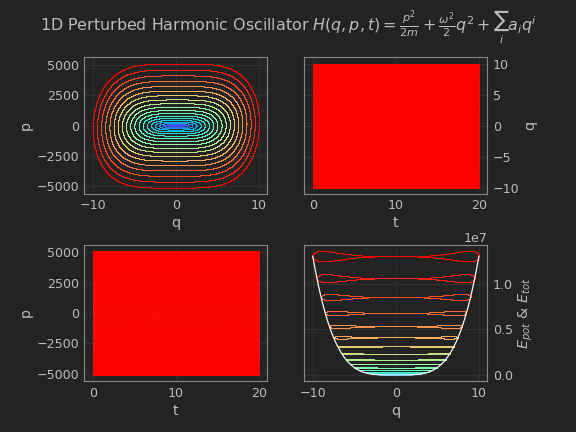

<IPython.core.display.Javascript object>


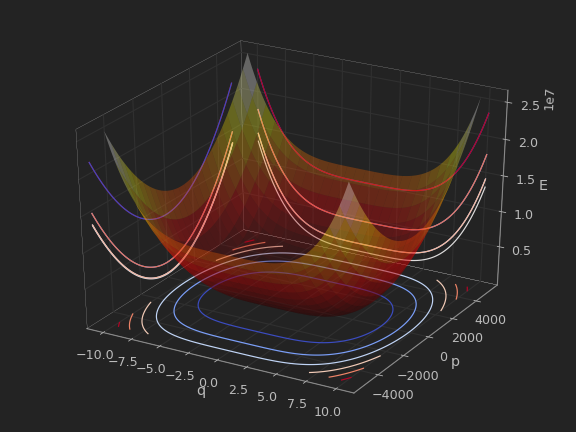

In [7]:
def Tkin(p, m):
    return p**2/2/m
    
def Upot(q, w, a0, a1, a2, a3, a4):
    return w**2*q**2/2 + a0 + a1*q + a2*q**2 + a3*q**3 + a4*q**4

def eom(q0, p0, dt, m, w, a0, a1, a2, a3, a4):
    dp = - (w**2*q0 + a1 + 2*a2*q0 + 3*a3*q0**2 + 4*a4*q0**3)*dt
    p = p0 + dp
    dq = p/m*dt
    q = q0 + dq
#     p[abs(p) > 6e3] = nan
#     q[abs(p) > 6e3] = nan
    return q, p

#### INTERACTIVE
# points = int(21)
# dt = 1.2e-3   # in s
# T = 20      # in s  (iterations = T/dt)
# q0 = linspace(0, 12, points)
# p0 = linspace(0, 0, points)
# m = 1
# fig1, fig2, axes, lines, ax3D, t, iterations, q, p, U = init(T, q0, p0, points, 'w')
# slides = widgets.interactive(lambda f, a0, a1, a2, a3, a4: run(lambda p: Tkin(p, m),
#                                                                lambda q: Upot(q, twopi*f, a0, a1, a2, a3, a4*1e3),
#                                                                lambda q, p: eom(q, p, dt, m, twopi*f, a0, a1, a2, a3, a4*1e3),
#                                                                axes, lines, ax3D, t, iterations, q, p, U, dt, 'w'),
#                                                                f=FloatSlider(min=0.01, max=1, step=0.05, continuous_update=False, layout=layout, style=style),
#                                                                a0=FloatSlider(min=-1, max=1, step=0.01, continuous_update=False, layout=layout, style=style),
#                                                                a1=FloatSlider(min=-1, max=1, step=0.01, continuous_update=False, layout=layout, style=style),
#                                                                a2=FloatSlider(min=-1, max=1, step=0.01, continuous_update=False, layout=layout, style=style),
#                                                                a3=FloatSlider(min=-1, max=1, step=0.01, continuous_update=False, layout=layout, style=style),
#                                                                a4=FloatSlider(min=-1, max=1, step=0.01, continuous_update=False, layout=layout, style=style))
# display(slides)

### PREDEFINED
points = int(21)
dt = 1e-4   # in s
T = 20      # in s  (iterations = T/dt)
# # concatenate([linspace(-7, 7, points-2), array([0, 10.1])]) (-10, -9.6, points)  [-12, 12]
#q0 = concatenate([linspace(-11.18, -8, 20), linspace(8, 11.18, 20), array([11.19]), array([11.3])])
q0 = linspace(0, 10, points)
p0 = linspace(0, 0, points)
m, f, a0, a1, a2, a3, a4 = 1, twopi*0.01, 0, 0, 0, 0, 1.3e3  # many fake FP
#m, f, a0, a1, a2, a3, a4 = 1, 1, 0, 0, -1, 0, 0.004  # two FP
    
def makeplots(fs, bw, path):
    fig1, fig2, axes, lines, ax3D, t, iterations, q, p, U = init(T, q0, p0, points, bw, fs=fs)
    run(lambda p: Tkin(p, m),
        lambda q: Upot(q, f, a0, a1, a2, a3, a4),
        lambda q, p: eom(q, p, dt, m, f, a0, a1, a2, a3, a4),
        axes, lines, ax3D, t, iterations, q, p, U, dt, bw)
    fig1.suptitle(r'1D Perturbed Harmonic Oscillator $H(q, p, t) = \frac{p^2}{2m} + \frac{\omega^2}{2}q^2 + \sum_i a_iq^i$')
#    fig1.savefig(path + '20171115_1DPHO_NSFP_dt1e-4')
#    fig2.savefig(path + '20171115_1DPHO_NSFP_dt1e-4_mplot3d')
    return

fs, bw = rctablet()
path = '/home/inp/git/github/promotion/publications/diashow/plotstyle_monokai/'
makeplots(fs, bw, path)

#fs, bw = rcprint()
#path = '/home/inp/git/github/promotion/publications/diashow/plotstyle_grade3/'
#makeplots(fs, bw, path)
#show()

<H2>Accelerator</H2>
<h3>\begin{align}
      H(q, p, t) &= \\
         \dot{q} &= \\
         \dot{p} &= 
\end{align}</h3>

In [ ]:
''' Hénon-Heiles Equation
V(x, y) = (x**2 + y**2 + 2*x**2*y - 2/3*y**3)/2

H =  (px^2 + py^2 + Ax^2 + By^2)/2 + Dx^2 - Cy^3/3
     dp/dt = -dH/dq = -K*sin(q)*delta(t)
     dq/dt = +dH/dp = p
'''
# calculation settings
dt = 1e-4
points = int(40)
iterations = int(2e4)
K = 2
t = 1
q0 = linspace(0, 10, points)
p0 = linspace(0, 10, points)
colors, q, p, E = init(q0, p0, points, iterations)


def hamilton(q, p, t, K):
    return p**2/2 + K*cos(q)

def eom(q0, p0, m, w, y, dt):
    dp = -K*sin(q0)*dt
    p = p0 + dp
    dq = p*dt
    q = q0 + dq
    return q, p

def track(q, p, E, m, g, R, dt):
    for it in range(1, iterations):
        q0, p0 = q[it-1, :], p[it-1, :]
        E[it-1, :] = hamilton(q0, p0, t, K)
        q[it, :], p[it, :] = eom(q0, p0, m, w, y, dt)
    E[it, :] = hamilton(q[it, :], p[it, :], t, K)
    return q, p, E

q, p, E = track(q, p, E, m, g, R, dt)
showplots(q, p, E, colors, ms=1)

$$H(q, p, t) = \frac{p_x^2 + p_y^2}{2} + \frac{x^2}{2\rho^2(s)}$$